# Contextual linear bandit with Thompson sampling

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Context-free multi-armed Bernoulli bandit

In [3]:
from jax.scipy.stats import beta
from jax import random
from jax.nn import one_hot

In [4]:
def thompson_sampling_step(state, key):
    alphas, betas, probs = state
    keys = key
    K = len(alphas)
    
    # Choose an arm to pull
    # (Sample from the policy distribution)
    theta_t = random.beta(key, alphas, betas).argmax()
    # Pull the arm and observe reward (either 1 or 0)
    reward = random.bernoulli(key, probs[theta_t])
    
    # Update policy distribution
    ind_vector = one_hot(theta_t, K)
    alphas_posterior = alphas + ind_vector * reward
    betas_posterior = betas + ind_vector * (1 - reward)
    
    return (alphas_posterior, betas_posterior, probs), (alphas_posterior, betas_posterior)

In [5]:
T = 200
key = random.PRNGKey(314)
keys = random.split(key, T)
probs = jnp.array([0.65, 0.4, 0.5, 0.9])
#probs = jnp.ones(5) * 0.5
K = len(probs)


alpha_priors = jnp.ones(K) * 1
beta_priors = jnp.ones(K) * 1

init_state = (alpha_priors, beta_priors, probs)
posteriors, hist = jax.lax.scan(thompson_sampling_step, init_state, keys)
alpha_posterior, beta_posterior, _ = posteriors
alpha_hist, beta_hist = hist

alpha_posterior, beta_posterior

(DeviceArray([  8.,   9.,  18., 140.], dtype=float32),
 DeviceArray([ 4.,  7., 11., 11.], dtype=float32))

In [6]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], alpha_hist[None, ...], beta_hist[None, ...])

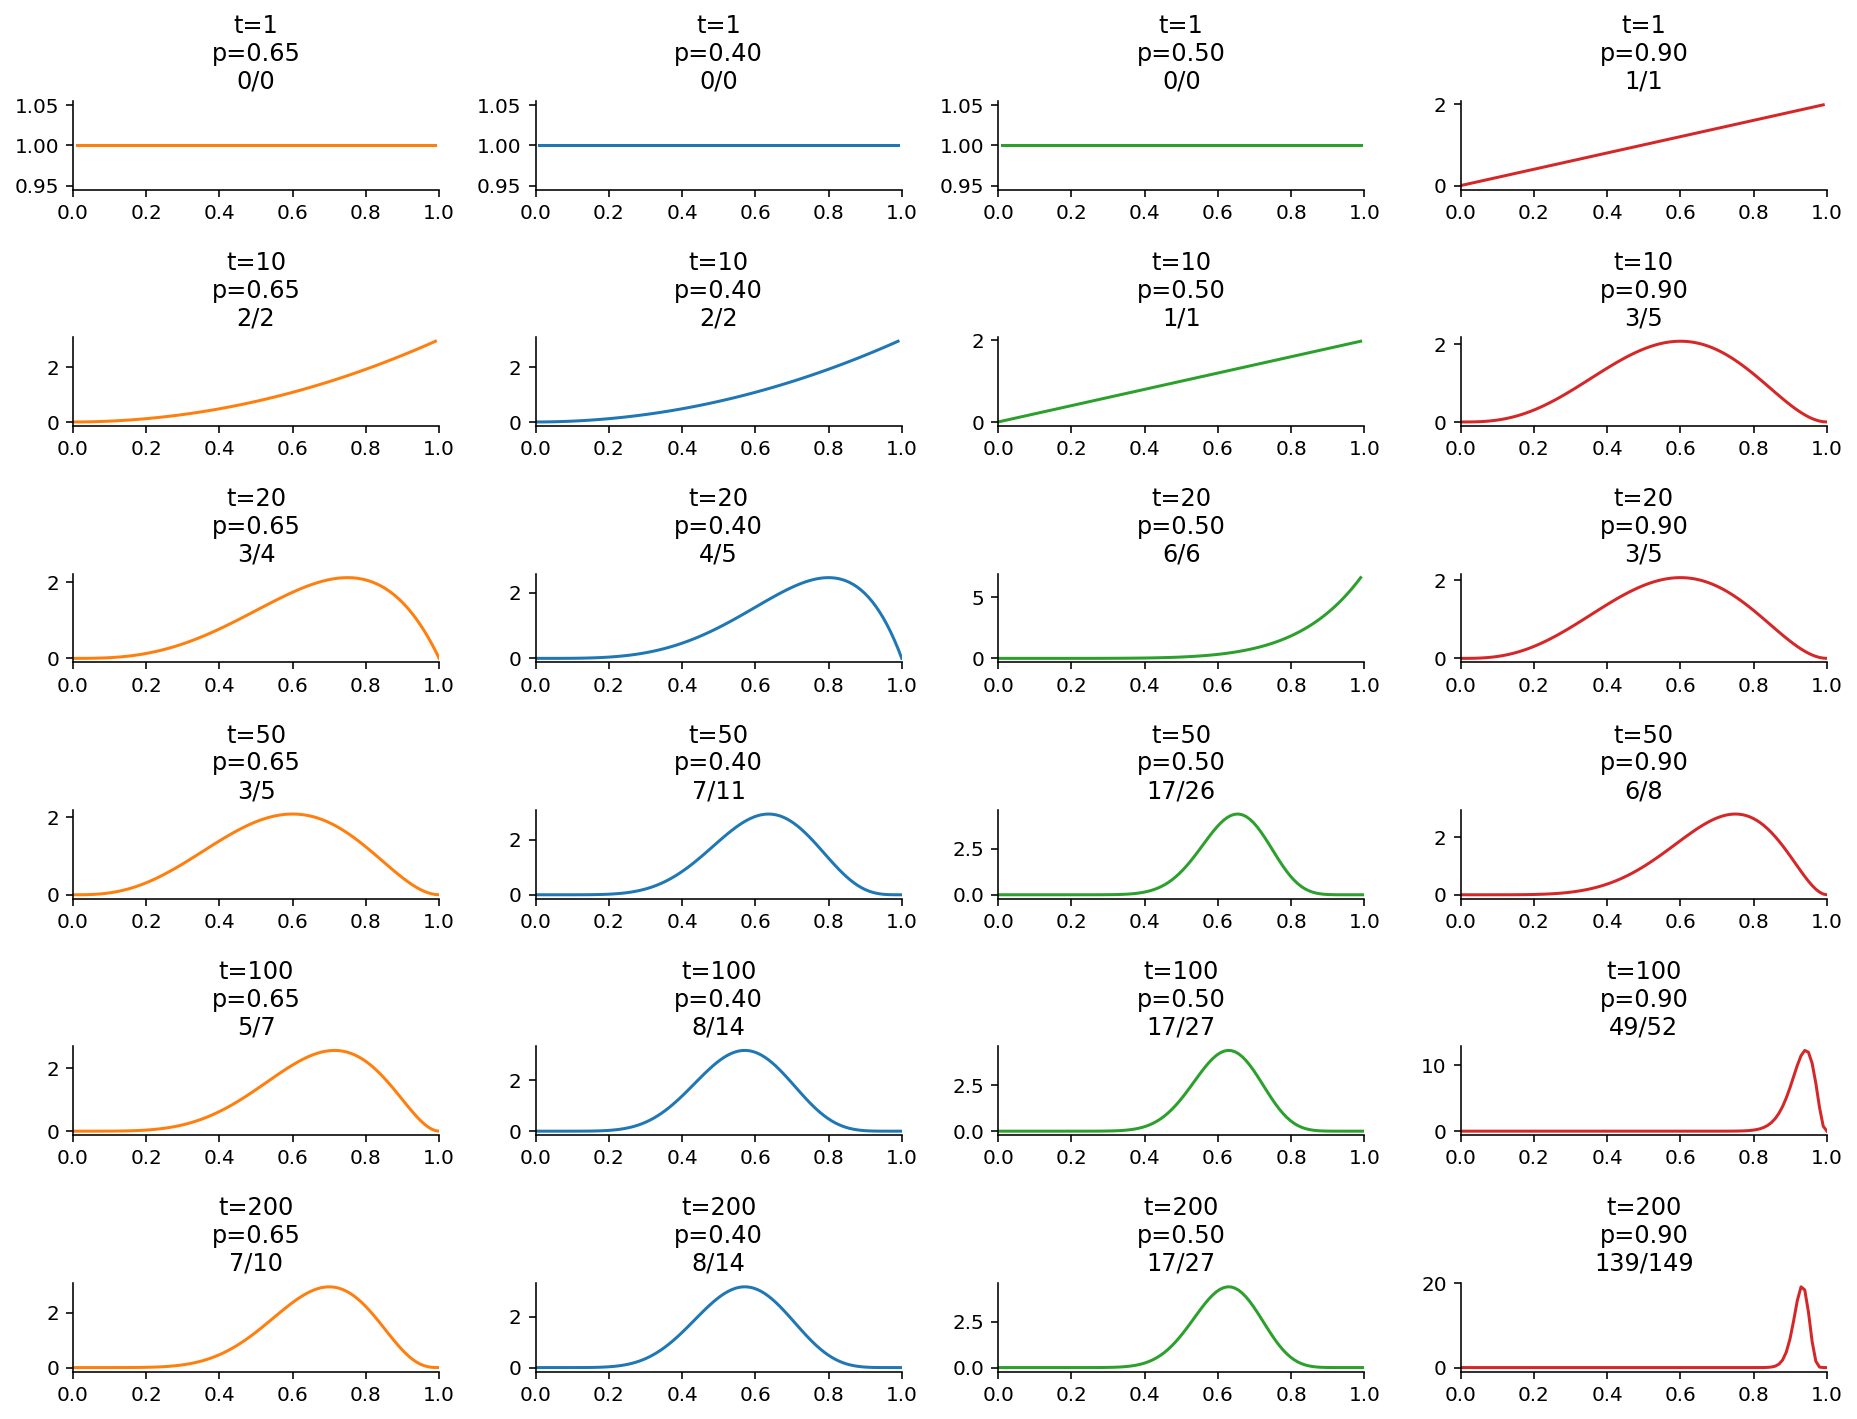

In [7]:
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]
# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = alpha_hist[t, k].item() - 1
        n_trials = beta_hist[t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={probs[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

## A better API

In [189]:
from functools import partial

class BetaBernoulliBandits:
    def __init__(self, K):
        self.K = K
        
    def sample(self, key, params):
        alphas = params["alpha"]
        betas = params["beta"]
        params_sample = random.beta(key, alphas, betas)
        return params_sample
    
    def predict_rewards(self, params_sample):
        return params_sample
            
    def update(self, action, params, reward):
        alphas = params["alpha"]
        betas = params["beta"]
        # Update policy distribution
        ind_vector = one_hot(action, self.K)
        alphas_posterior = alphas + ind_vector * reward
        betas_posterior = betas + ind_vector * (1 - reward)
        return {
            "alpha": alphas_posterior,
            "beta": betas_posterior
        }


def true_reward(key, action, mean_rewards):
    """
    Reward after taking an action
    """
    reward = random.bernoulli(key, mean_rewards[action])
    return reward
    

def thompson_sampling_step(model_params, key, model, environment):
    """
    Context-free implementation of the Thompson sampling algorithm.
    This implementation considers a single step
    
    Parameters
    ----------
    model_params: dict
    environment: function
    key: jax.random.PRNGKey
    moidel: instance of a Bandit model
    """
    key_sample, key_reward = random.split(key)
    params = model.sample(key_sample, model_params)
    pred_rewards = model.predict_rewards(params)
    action = pred_rewards.argmax()
    # environment
    reward = environment(key_reward, action)
    model_params = model.update(action, model_params, reward)
    
    prob_arm = model_params["alpha"] / (model_params["alpha"] + model_params["beta"])
    
    return model_params, (model_params, prob_arm)

T = 200
key = random.PRNGKey(31415)
keys = random.split(key, T)
mean_rewards = jnp.array([0.4, 0.5, 0.2, 0.9])
K = len(mean_rewards)
bbbandit = BetaBernoulliBandits(mean_rewards)
init_params = {"alpha": jnp.ones(K),
               "beta": jnp.ones(K)}

environment = partial(true_reward, mean_rewards=mean_rewards)
thompson_partial = partial(thompson_sampling_step,
                           model=BetaBernoulliBandits(K),
                           environment=environment)
posteriors, (hist, prob_arm_hist) = jax.lax.scan(thompson_partial, init_params, keys)

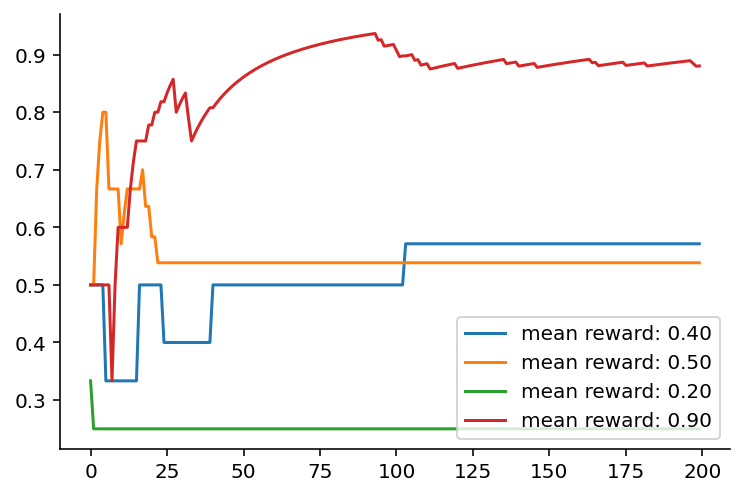

In [190]:
plt.plot(prob_arm_hist)
plt.legend([f"mean reward: {reward:0.2f}" for reward in mean_rewards], loc="lower right")

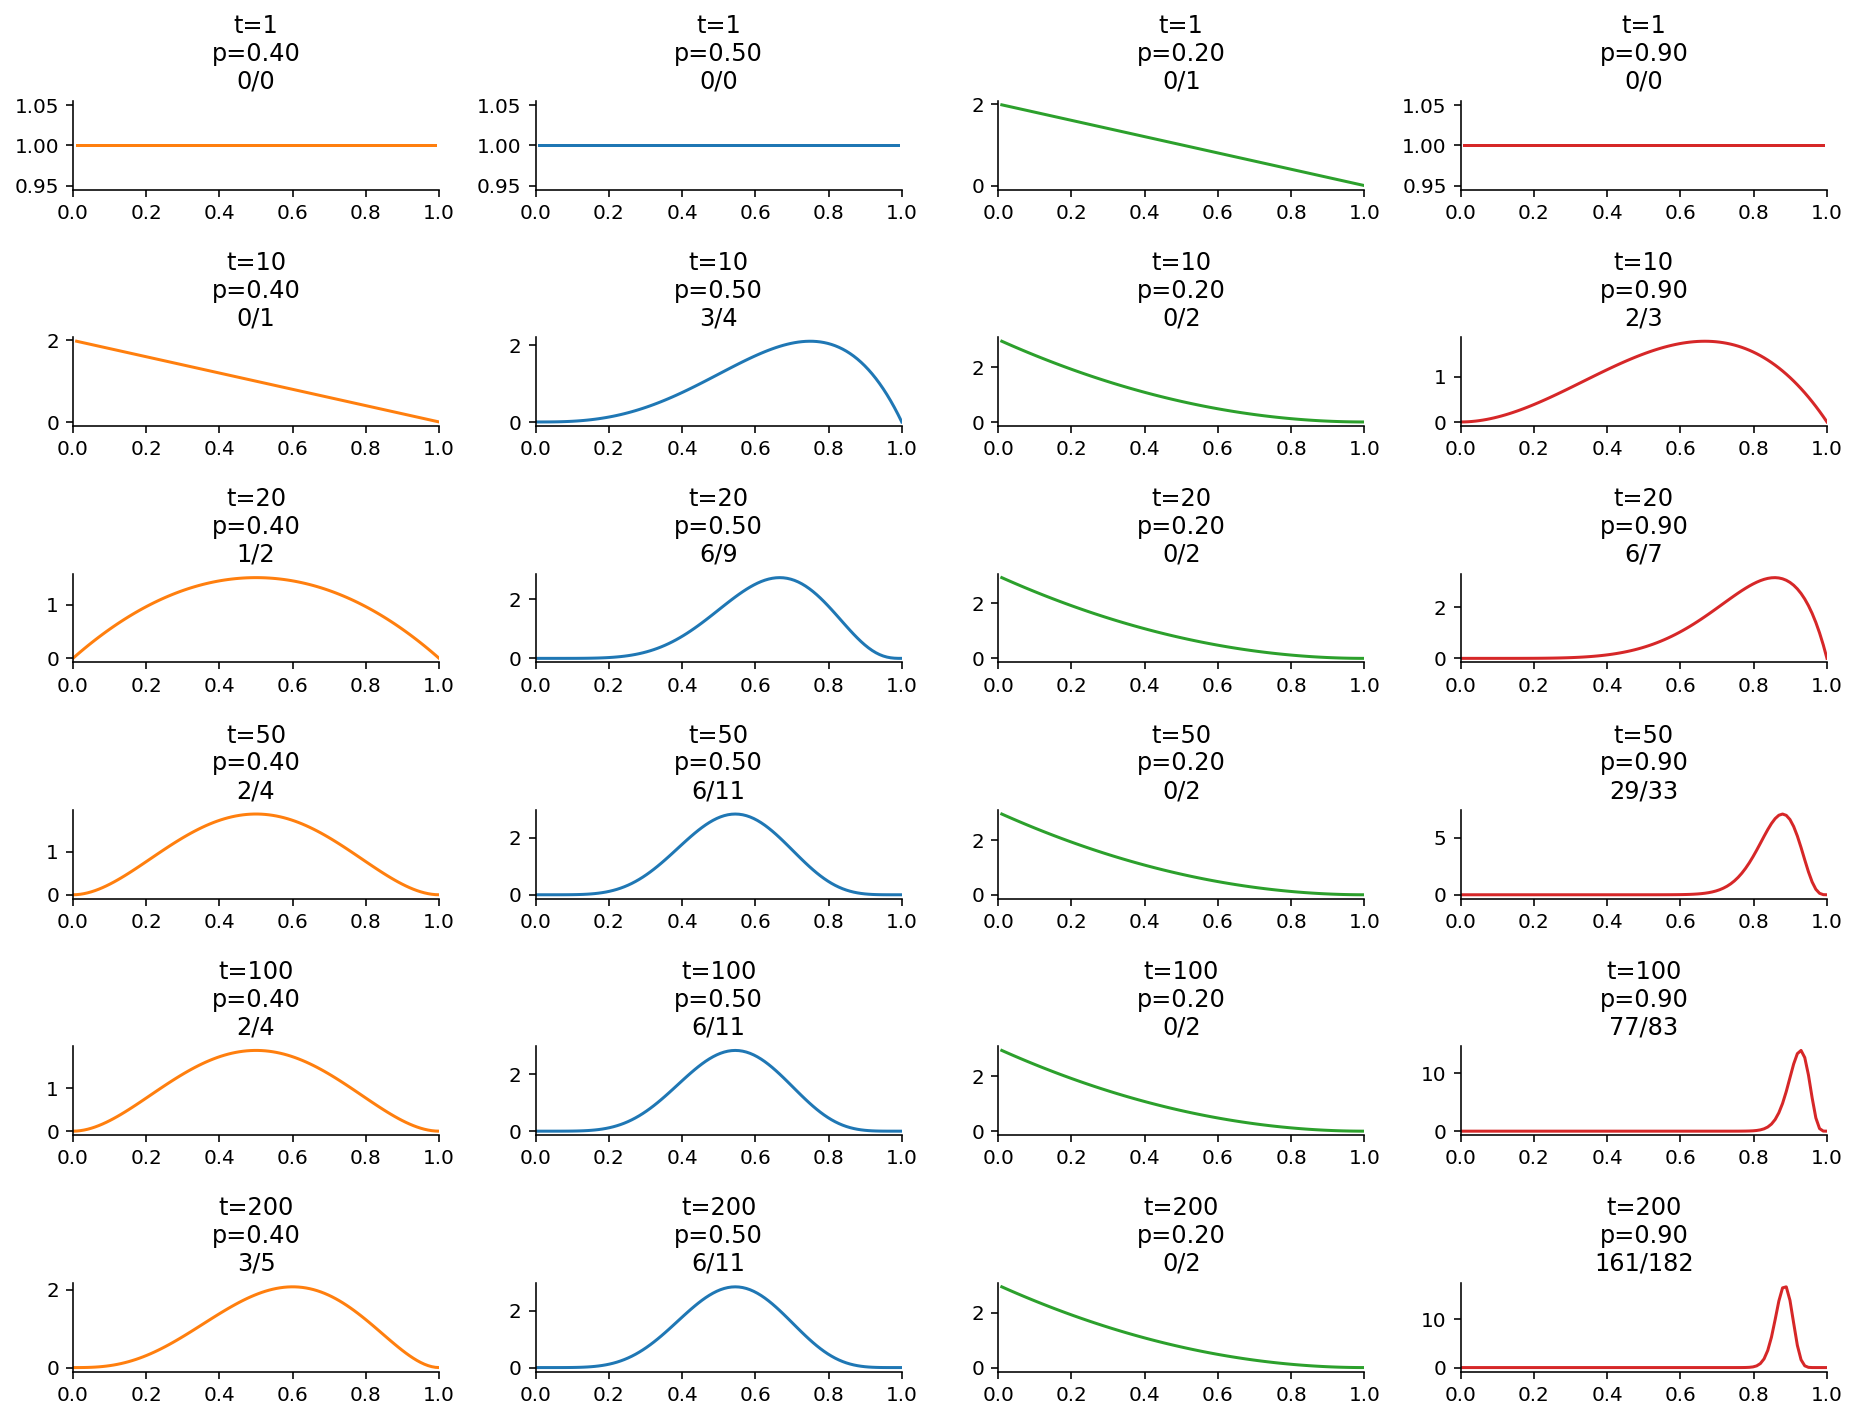

In [187]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], hist["alpha"][None, ...], hist["beta"][None, ...])
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]

# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = hist["alpha"][t, k].item() - 1
        n_trials = hist["beta"][t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={mean_rewards[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

# Contextual multiarmed Normal bandit
## Linear case

In [98]:
class NormalGammaBandit:
    
    def sample(self, key, params, state):
        ...
    
    
    def predict_rewards(self, params_sample):
        ...
    
    
    def true_reward(self, key, action):
        ...
    
    
    def update(selc, action, params, reward):
        ...

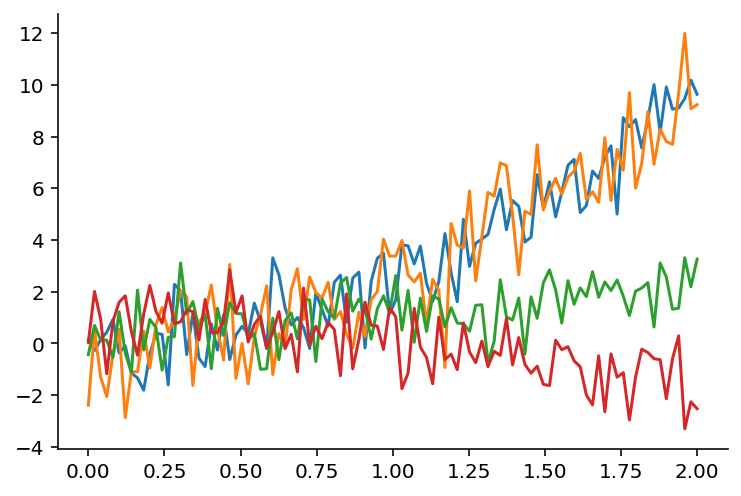

In [162]:
W = jnp.array([
    [-0.5, 1.0, 2.0],
    [-0.5, 1.0, 2.0],
    [1.0, -0.3, 0.5],
    [1.0, -0.3, -0.5]
])

K, M = W.shape

sigmas = jnp.array([1.0, 2.0, 1.0, 1.0])

noise = random.multivariate_normal(key, mean=jnp.zeros(K), cov=jnp.eye(K) * sigmas, shape=(N,))
Y = jnp.einsum("nm,km->nk", X, W) + noise


plt.plot(x, Y);

In [13]:
class NormalGammaBandit:
    def __init__(sel):
        self.mu = mu
        self.sigma = sigma
        self.b = b
        self.a = a
        self.K = len(mean_rewards)
    
    def sample(self, key, params, state):
        sigma2_samp = tfd.InverseGamma(concentration=init_params["a"], scale=init_params["b"]).sample(seed=key)
        w_samp = tfd.MultivariateNormalFullCovariance(loc=init_params["mu"], covariance_matrix=cov_matrix_samples).sample(seed=key)
        return sigma2_samp, w_samp
        
    def predict_rewards(self, params_sample, state):
        sigma2_samp, w_samp = params_sample
        predicted_reward = jnp.einsum("m,km->k", state, w_samp)
        return predicted_reward
    
    def true_reward(self, key, action):
        # What is this?
        # take out of this class
        ...
    
    def update(selc, action, params, reward):
        ...

In [36]:
M = 3
eta = 1
# test state
state = random.normal(key, (M,))
init_params = {
    "mu": jnp.zeros((K, M)),
    "Sigma": jnp.eye(M) * jnp.ones((K, 1, 1)),
    "a": eta * jnp.ones(K),
    "b": eta * jnp.ones(K),
}

In [39]:
init_params["mu"][0]

DeviceArray([0., 0., 0.], dtype=float32)

In [30]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [41]:
key = random.PRNGKey(314)
sigma2_samp = tfd.InverseGamma(concentration=init_params["a"], scale=init_params["b"]).sample(seed=key)
sigma2_samp

DeviceArray([0.23249085, 0.66998446, 0.7994766 , 0.7747986 ], dtype=float32)

In [68]:
cov_matrix_samples = sigma2_samp[:, None, None] * init_params["Sigma"]
w_samp = tfd.MultivariateNormalFullCovariance(loc=init_params["mu"], covariance_matrix=cov_matrix_samples).sample(seed=key)
w_samp

DeviceArray([[-1.3271687 ,  0.5097211 ,  0.05109857],
             [-0.5033796 ,  0.0271854 ,  0.10800622],
             [ 0.56792307,  2.3608057 , -0.5347049 ],
             [ 0.7374862 ,  0.9128318 ,  0.60278165]], dtype=float32)

In [79]:
jnp.einsum("m,km->k", state, w_samp)

DeviceArray([-0.12467887, -0.11456975, -0.36159694, -1.5929668 ], dtype=float32)

## References
* https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching